### EDA Part 3 Notebook -- Understanding Results Linear Model
#### Data 200 - Graduate Student Final Project
#### Team Members: Erin Jones, Filipe Santos

Once the raw data was explored, features were engineered and a pipeline was created. These users were run through the pipeline and csv's were extracted from the new design matrix, phi. This allowed us to explore and validate the relationships between some of the features that were engineered. This is done via the same process, where the subdirectory is 'processed_selected'.

These numbers [1040960, 9359950, 8484809, 1663599, 3232625, 9937628] are the user IDs whose test sets were most well and least well represented by model one (from best to worst respectively). They will be taken to eda_3 to be evaluated further.

In [1]:
# IMPORTS

# Data Manipulation
import pandas as pd
import numpy as np
import random
import pickle
from math import radians, cos, sin, asin, sqrt

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Time zone + time stamp work
from timezonefinder import TimezoneFinder
import datetime
import pytz

# Sklearn model generation
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn import linear_model as lm
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# import data

# open pickle file to work with 
with open('./data/500_user.pkl', 'rb') as file:
    # dump into dictionary object
    users_dict = pickle.load(file)

# ensure load worked properly
for user, df in users_dict.items():
    print(len(users_dict))
    display(df.head())
    break

500


,since_begin,since_last,tar_derived_speed,heart_rate,distance,sport,tar_heart_rate,derived_speed,id,timestamp,altitude,gender,time_elapsed,longitude,latitude,userId,workout_n
0,-14.805054,-0.01158,0.000000,8.532873,-4.372304,run,179,-7.082944,649100510,1451317040,0.038282,male,-0.122568,25.276541,54.750948,1413935,35004
1,-14.805054,-0.01158,9.925434,8.532873,-2.989371,run,179,-3.134742,649100510,1451317046,0.023704,male,-0.122300,25.276727,54.750845,1413935,35004
2,-14.805054,-0.01158,11.857894,8.532873,-2.995481,run,179,-2.366035,649100510,1451317051,0.009125,male,-0.122077,25.276908,54.750740,1413935,35004
3,-14.805054,-0.01158,10.866049,8.321098,-3.110645,run,178,-2.760578,649100510,1451317056,0.009125,male,-0.121854,25.277104,54.750665,1413935,35004
4,-14.805054,-0.01158,13.632061,6.626896,-2.472918,run,170,-1.660296,649100510,1451317062,-0.005454,male,-0.121587,25.277388,54.750543,1413935,35004


#### Create Pipeline Functions and Modified Pipeline

In [3]:
# Remove outliers
def remove_outliers(data, variable, upper=None, lower=None): 
    df = data.copy()
    mean = df[variable].mean()
    std = df[variable].std()
    if upper:
        upper_fence = upper
    else:
        upper_fence = mean + (3*std)
    if lower:
        lower_fence = lower
    else:    
        lower_fence = mean - (3*std)
    df = (df[(df[variable] >= lower_fence) & (df[variable] <= upper_fence)]).copy()
    return df

# Define a function to calculate timezone for a group
def add_dt(data):

    def calculate_timezone(group_df):
        lat = group_df['latitude'].iloc[0]
        long = group_df['longitude'].iloc[0]
        try:
            # Create a TimezoneFinder object
            tf = TimezoneFinder()
            # Find the timezone based on coordinates
            timezone = tf.timezone_at(lng=long, lat=lat)
        except:
            timezone = 'UTC'
        return timezone
    
    def create_datetime(row):
        
        # Unix timestamp
        ts = row['timestamp']

        # Specify the timezone (e.g., 'America/New_York')
        desired_timezone = row['tz']

        # Convert Unix timestamp to a datetime object with the desired timezone
        datetime_obj = datetime.datetime.utcfromtimestamp(ts)
        desired_timezone_obj = pytz.timezone(desired_timezone)
        localized_datetime = desired_timezone_obj.localize(datetime_obj)
        

        # # Format the localized datetime object as a string
        # formatted_date_time = localized_datetime.strftime('%Y-%m-%d %H:%M:%S %Z')
        return localized_datetime

    # Group the DataFrame by the 'Group' column and calculate timezone
    grouped_timezone = data.groupby('workout_n').apply(calculate_timezone)
    # Use transform to broadcast timezone to all rows in each group
    data['tz'] = data['workout_n'].map(grouped_timezone)
    data['datetime'] = data.apply(create_datetime,axis=1)
    
    return data

def add_tod(data):
    """
    Adds a new column to the dataframe categorizing the time of day based on the timestamp.

    Categories:
    0 - Night (00:00-04:59)
    1 - Early Morning (05:00-06:59)
    2 - Mid Morning (07:00-08:59)
    3 - Midday (09:00-10:59)
    4 - Early Afternoon (11:00-13:59)
    5 - Late Afternoon (14:00-16:59)
    6 - Evening (17:00-23:59)

    Parameters:
    data (pd.DataFrame): input workout timeseries
    column (str): column containing the timestamp.

    Returns:
    pd.DataFrame: The DataFrame with the new categorization column.
    """

    def get_time_category(hour):
        if 0 <= hour <= 4:
            return 0  # Night
        elif 5 <= hour <= 6:
            return 1  # Early Morning
        elif 7 <= hour <= 8:
            return 2  # Mid Morning
        elif 9 <= hour <= 10:
            return 3  # Midday
        elif 11 <= hour <= 13:
            return 4  # Early Afternoon
        elif 14 <= hour <= 16:
            return 5  # Late Afternoon
        else:
            return 6  # Evening

    if 'datetime' in data.columns:
    #     # Extract hour from the timestamp
    #     # Create a new column by extracting the hour from the datetime column
        data['hour'] = data['datetime'].apply(lambda x: x.hour)
        data['time_category'] = data['hour'].apply(get_time_category)
    else:
        raise ValueError(f"Column 'datetime' not found in DataFrame.")

    return data

def add_mins_elapsed(data):

    def cumulative_by_group(group_df):

        # calc the running difference
        group_df['diff'] = (group_df['timestamp'].diff())/60
        # fill row 1
        group_df['diff'].iloc[0] = 0
        # calculate the cumulative sum
        group_df['elapsed'] = group_df['diff'].cumsum()

        return group_df

    grouped = data.groupby('workout_n')
    data = grouped.apply(cumulative_by_group)
    data.reset_index(drop=True, inplace=True)

    return data

def log_transform(data, **columns):
    def conditional_log(value):
        if value >= 1:
            return np.log(value)
        else:
            return value 
    for col, name in columns.items():
        data[f'log_{name}'] = data[name].apply(conditional_log)
    return data

def ohe_categorical(data, column_name):
    """
    One-hot-encodes categorical variable. New columns are of the form "'col_name'_NUMBER".
    We drop the first column to allow the intercept to remain in the regression model while
    avoiding multicollinearity
    """
    enc = OneHotEncoder(drop='first')
    o_h_e = (enc.fit_transform(data[[column_name]])).toarray()
    one_hot_encoded_df = (pd.DataFrame(o_h_e, columns=enc.get_feature_names_out([column_name]))).set_index(data.index)
    data = data.merge(one_hot_encoded_df, left_index=True, right_index=True)
    return data

def add_haversine_col(data):
    def single_pt_haversine(row):
        """
        'Single-point' Haversine: Calculates the great circle distance
        between a point on Earth and the (0, 0) lat-long coordinate
        """
        lat = row['latitude']
        lng = row['longitude']
        r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

        lat, lng = map(radians, [lat, lng])
            
        # 'Single-point' Haversine formula
        a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
        d = 2 * r * asin(sqrt(a)) 
        
        return d
    data['haversine'] = data.apply(single_pt_haversine, axis=1)
    return data

def add_haversine_col(data):
    def single_pt_haversine(row):
        """
        'Single-point' Haversine: Calculates the great circle distance
        between a point on Earth and the (0, 0) lat-long coordinate
        """
        lat = row['latitude']
        lng = row['longitude']
        r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

        lat, lng = map(radians, [lat, lng])
            
        # 'Single-point' Haversine formula
        a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
        d = 2 * r * asin(sqrt(a)) 
        
        return d
    data['haversine'] = data.apply(single_pt_haversine, axis=1)
    return data

def min_max_scale_columns(df, columns):
    """
    Applies Min-Max scaling to specified columns of a DataFrame.

    Args:
    df (pd.DataFrame): The DataFrame to be scaled.
    columns (list): List of column names to be scaled.

    Returns:
    pd.DataFrame: The DataFrame with specified columns scaled.
    """
    scaler = MinMaxScaler()

    for col in columns:
        if col in df.columns:
            # Reshape data for scaling
            data = df[col].values.reshape(-1, 1)
            # Scale the data and replace in the DataFrame
            df[col] = scaler.fit_transform(data)
        else:
            print(f"Column {col} not found in DataFrame.")

    return df

In [4]:
def process_data_pipe_wo_selection(data, pipeline_functions, prediction_col=None, features=None):

    # run pipeline functions
    for function, positional_arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not positional_arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (positional_arguments):
            data = data.pipe(function, *positional_arguments)
        else:
            data = data.pipe(function)
    

    # create x_y split

    df = data.dropna()
    # drop interim columns added prior to running feature selector
    X = df.drop(columns=[prediction_col,'latitude', 'longitude', 'timestamp', 'hour', 'time_elapsed', 'diff'])
    y = df.loc[:, prediction_col]

    return X, y

def process_data_interim(data):
    
    df = data.copy()
    drop_cols = ['since_begin', 'since_last', 'id', 'gender', 'userId', 'heart_rate', 'derived_speed']
    mod_cols = [col for col in drop_cols if col in df.columns]
    
    # drop columns with data which is not useful
    df.drop(columns=mod_cols, inplace=True)

    # need to confirm that we would like to do this
    df.dropna(inplace=True)

    processing_all = [
        (ohe_categorical, None, {'column_name': 'sport'}), 
        (add_haversine_col, None, None), 
        (add_dt, None, None), 
        (add_tod, None, None),
        (add_mins_elapsed, None, None),
        ]
    
    processing_training = [
        (remove_outliers, None, {'variable': 'tar_heart_rate'}), 
        # (log_transform, None, {'col': 'tar_heart_rate'})
        ]
    processing_steps = processing_training + processing_all
    X, y = process_data_pipe_wo_selection(df, pipeline_functions=processing_steps, prediction_col='tar_heart_rate', features=None)
    p_df = pd.DataFrame(X)
    p_df['hr_bpm'] = y
    return X, y, p_df

In [6]:
def plot_corr_matrix(df, userId):
    """Calculate and plot a correlation matrix

    Args:
    df (pd.DataFrame): User dataframe containing multiple workouts
    columns: a list of the desired columns

    Returns:
    plotted correlation matrix
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # compute correlation matrix for specified columns
    corr_matrix = df[numeric_cols].corr()

    # create heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

    plt.title(f'{userId} Correlation Matrix')

    # show plot
    return plt.show()



user_dfs = [users_dict[1040960], users_dict[9359950], users_dict[8484809], users_dict[1663599], users_dict[3232625], users_dict[9937628]]
keys_of_interest = [1040960, 9359950, 8484809, 1663599, 3232625, 9937628]
user_correlations = {}

for i, df in enumerate(user_dfs, start=1):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    user_correlations[f'User {keys_of_interest[i]}'] = df[numeric_cols].corr()['hr_bpm'].drop('bpm')

combined_df = pd.DataFrame(user_correlations)

# Plotting
combined_df.plot(kind='bar', figsize=(10, 6))
plt.title('Correlation with Target Variable by User')
plt.xlabel('Feature')
plt.ylabel('Correlation Coefficient')
plt.legend(title='User')
plt.show()


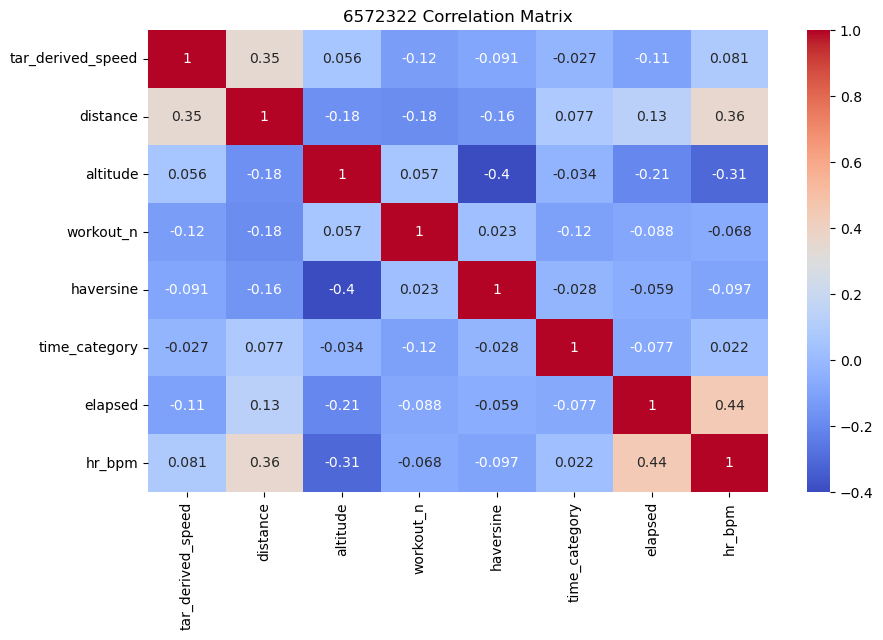

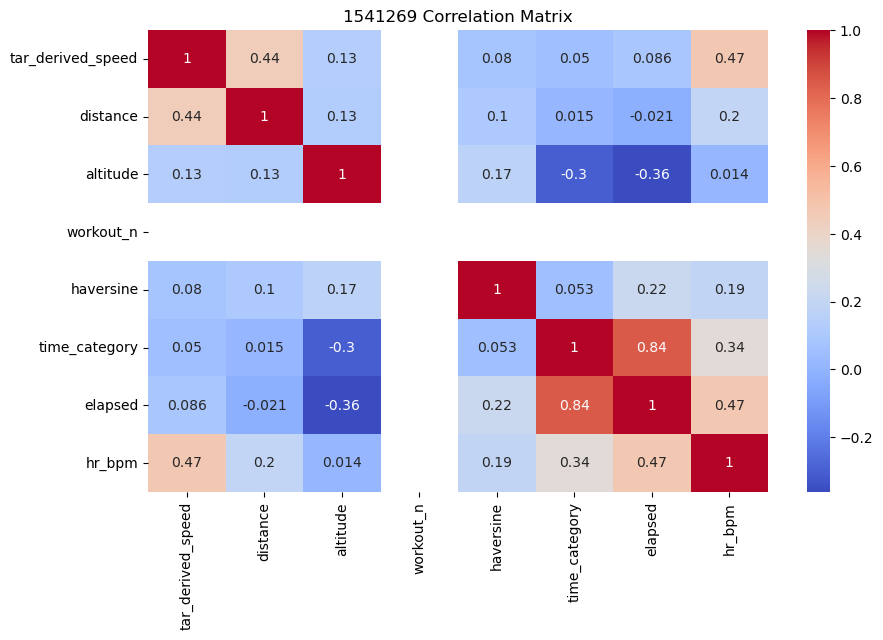

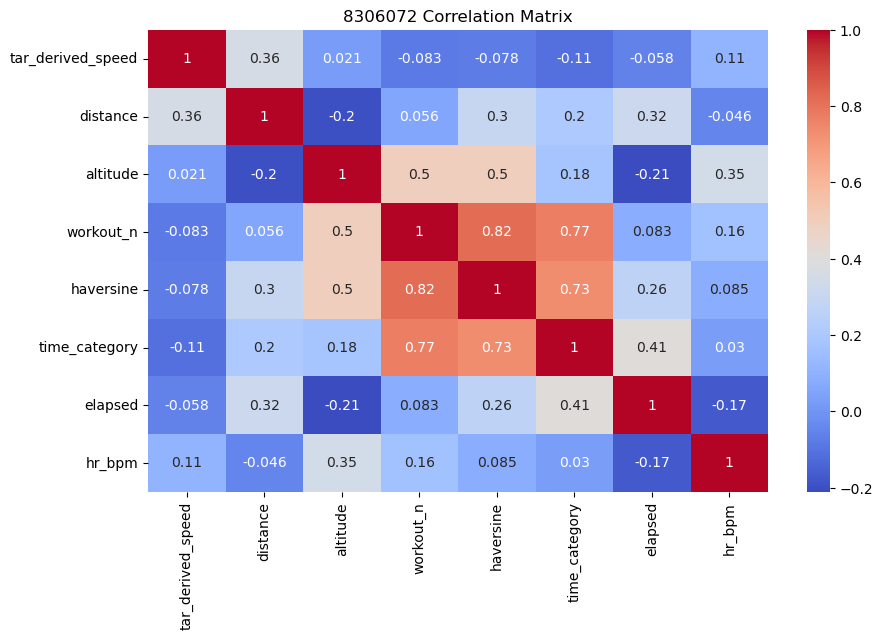

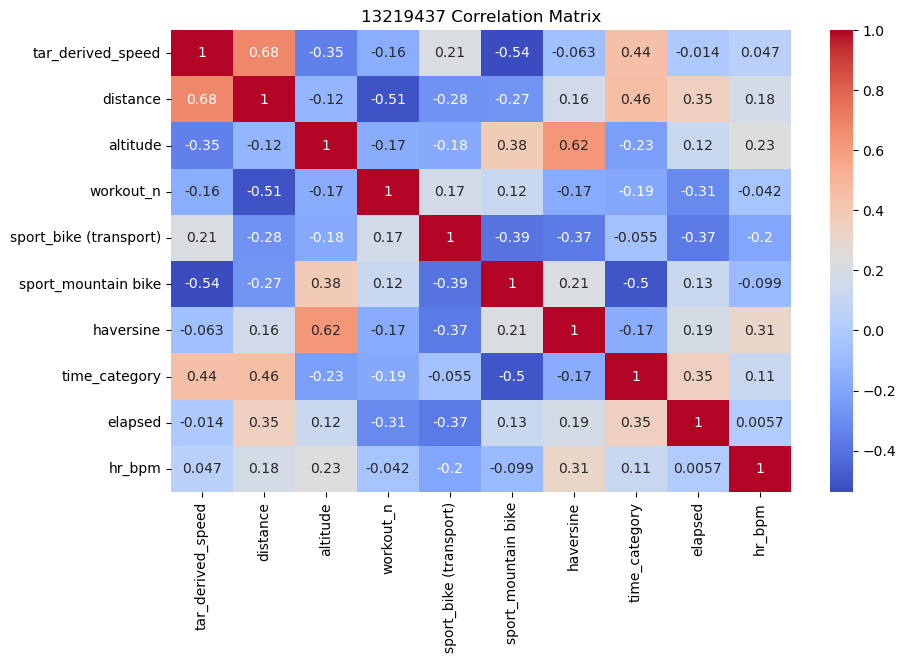

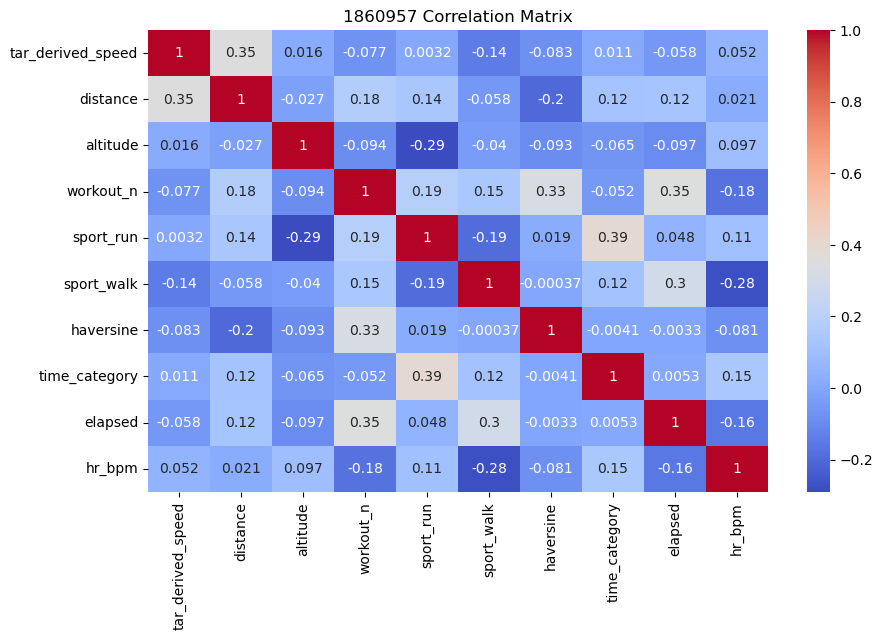

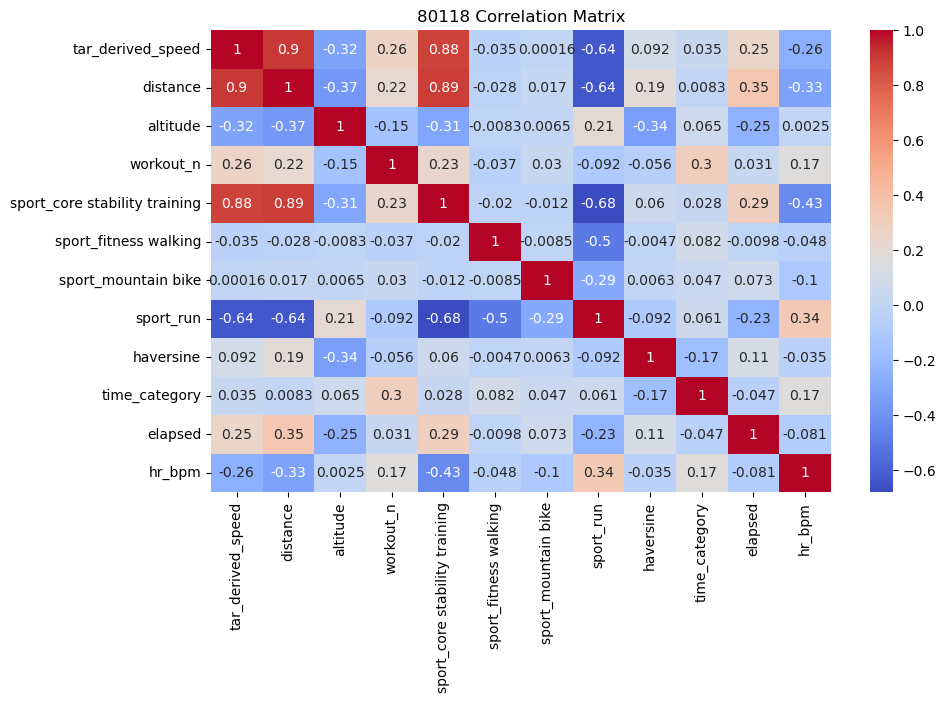

In [7]:
keys_of_interest = [1040960, 9359950, 8484809, 1663599, 3232625, 9937628]
best_and_worst = {k: subsample[k] for k in keys_of_interest if k in subsample}

for user, df in best_and_worst.items():
    X, y, data = process_data_interim(df)
    plot_corr_matrix(data, user)

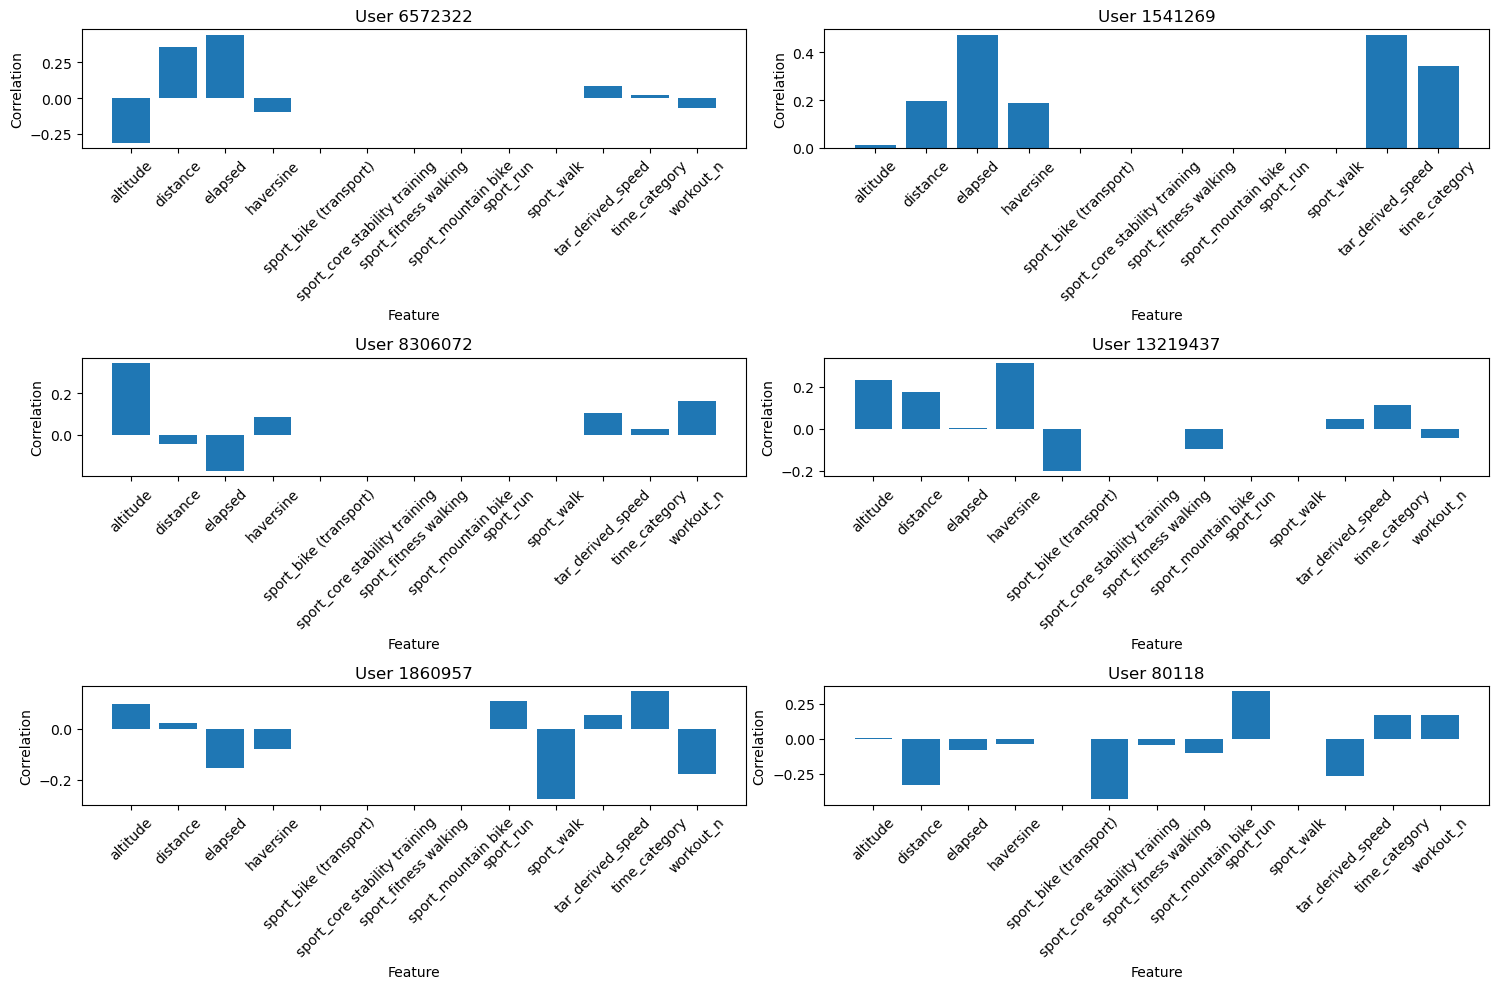

In [27]:
user_dfs = [subsample[6572322], subsample[1541269], subsample[8306072], subsample[13219437], subsample[1860957], subsample[80118]]
keys_of_interest =[6572322, 1541269, 8306072, 13219437, 1860957, 80118]

# calc correlations
correlations = {}
for user, df in zip(keys_of_interest, user_dfs):
    X, y, data = process_data_interim(df)
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    corr_with_target = data[numeric_cols].corrwith(data['hr_bpm']).drop('hr_bpm')
    correlations[user] = corr_with_target

# create df from the correlations
corr_df = pd.DataFrame(correlations).T
corr_df = corr_df.reset_index().melt(id_vars='index', var_name='Feature', value_name='Correlation')
corr_df = corr_df.rename(columns={'index': 'User'})

# unique groups
groups = corr_df['User'].unique()

# create subplot for each group
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # flatten the axes array

# Plot each group in its subplot
for ax, group in zip(axes, groups):
    group_data = corr_df[corr_df['User'] == group]
    ax.bar(group_data['Feature'], group_data['Correlation'])
    ax.set_title(f'User {group}')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Correlation')
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

plt.tight_layout()
plt.show()

In [28]:
# import and process data
with open('./data/mega_train_lm.pkl', 'rb') as file:
    training_results = pickle.load(file)

with open('./data/mega_test_lm.pkl', 'rb') as file:
    testing_results = pickle.load(file)

# create df for ease of manipulation and graphing for rmse
data_train = [(key, *value) for key, value in training_results.items()]
df_train = pd.DataFrame(data_train, columns=['user_id', 'rmse', 'x_train', 'y_train', 'y_fitted', 'feats'])

data_test = [(key, *value) for key, value in testing_results.items()]
df_test = pd.DataFrame(data_test, columns=['user_id', 'rmse', 'x_test', 'y_test', 'y_predicted'])

In [ ]:
def plot_pred_v_resid(df):   
 # Calculate Residuals
    df['resid'] = df['act'] - df['pred']

    # Create Plot
    fig = go.Figure()

    # Add scatter plot
    fig.add_trace(go.Scatter(x=df['pred'], y=df['resid'], mode='markers', name='Residuals'))

    # Update layout
    fig.update_layout(title='Predicted vs Residuals',
                    xaxis_title='Predicted Values',
                    yaxis_title='Residuals',
                    hovermode='closest')

    # Show plot
    return fig.show()